In [1]:
import duckdb

with duckdb.connect('data/sakila.duckdb') as conn:
    description = conn.sql("DESC;").df()

dfs = {}

with duckdb.connect('data/sakila.duckdb') as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()
            duckdb.register(name, dfs[name])

TASK 1

a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [2]:
longest_movies = duckdb.sql("""--sql
               SELECT
                title,
                length
               FROM film
               WHERE length > 180
               ORDER BY length DESC
               LIMIT 5;""").df()
longest_movies

,title,length
0,CONTROL ANTHEM,185
1,CHICAGO NORTH,185
2,GANGS PRIDE,185
3,DARN FORRESTER,185
4,HOME PITY,185


b) Which movies have the word "love" in its title? Show the following columns:
   - title
   - rating
   - length
   - description

In [3]:
love_in_title = duckdb.sql("""--sql
               SELECT
                title,
                rating,
                length,
                description
               FROM film
               WHERE REGEXP_MATCHES(title, '(^| )LOVE($| )');""").df()
love_in_title

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and
   longest movie length

In [4]:
stats_length = duckdb.sql("""--sql
               SELECT
                MIN(length) AS shortest_film,
                MAX(length) AS longest_film,
                AVG(length) AS average_length,
                MEDIAN(length) AS median_length
               FROM film;""").df()
stats_length

,shortest_film,longest_film,average_length,median_length
0,46,185,115.272,114.0


d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can
   keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.

In [5]:
price_per_day = duckdb.sql("""--sql
               SELECT
                title,
                rental_rate/rental_duration AS price_per_day
               FROM film
               ORDER BY price_per_day DESC
               LIMIT 10;""").df()
price_per_day

,title,price_per_day
0,AMERICAN CIRCUS,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BILKO ANONYMOUS,1.663333
3,BEAST HUNCHBACK,1.663333
4,CARIBBEAN LIBERTY,1.663333
5,AUTUMN CROW,1.663333
6,CASPER DRAGONFLY,1.663333
7,ACE GOLDFINGER,1.663333
8,BEHAVIOR RUNAWAY,1.663333
9,CASUALTIES ENCINO,1.663333


e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have
   played in.

In [6]:
actor_ocurrence = duckdb.sql("""--sql
               SELECT
                fa.actor_id,
                a.first_name,
                a.last_name,
               COUNT(fa.film_id) AS frequency
               FROM actor a
               LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
               GROUP BY fa.actor_id, a.first_name, a.last_name
               ORDER BY frequency DESC
               LIMIT 10;""").df()
actor_ocurrence

,actor_id,first_name,last_name,frequency
0,107,GINA,DEGENERES,42
1,102,WALTER,TORN,41
2,198,MARY,KEITEL,40
3,181,MATTHEW,CARREY,39
4,23,SANDRA,KILMER,37
5,81,SCARLETT,DAMON,36
6,106,GROUCHO,DUNST,35
7,60,HENRY,BERRY,35
8,144,ANGELA,WITHERSPOON,35
9,13,UMA,WOOD,35


f) Now it's time for you to choose your own question to explore the sakila database! Write down 3-5
questions you want to answer and then answer them using pandas and duckdb.

- Which films ID:s in the film list do not exist in the inventory?

In [7]:
missing_id = duckdb.sql("""--sql
                        SELECT film_id FROM film
                        EXCEPT
                        SELECT film_id FROM inventory
                        ORDER BY film_id;""").df()

print(missing_id.values.flatten())

[ 14  33  36  38  41  87 108 128 144 148 171 192 195 198 217 221 318 325
 332 359 386 404 419 495 497 607 642 669 671 701 712 713 742 801 802 860
 874 909 943 950 954 955]


- Which actors have accounted for the largest portion of sales?

In [8]:
lucrative_actors = duckdb.sql("""--sql
                                SELECT
                                 a.actor_id,
                                 CONCAT(a.first_name, ' ', a.last_name) AS full_name,
                                 SUM(p.amount) AS amount
                                FROM actor a
                                LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
                                LEFT JOIN film f ON fa.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY a.actor_id,full_name
                                ORDER BY amount DESC;""").df()

lucrative_actors.head()

,actor_id,full_name,amount
0,107.0,GINA DEGENERES,3442.49
1,181.0,MATTHEW CARREY,2742.19
2,198.0,MARY KEITEL,2689.25
3,81.0,SCARLETT DAMON,2655.28
4,102.0,WALTER TORN,2620.62


- In case a store burns down the insurance company want data on the sum of the replacement costs of the films in each store

In [9]:
sum_replacement_cost = duckdb.sql("""--sql
                                SELECT
                                 s.address_id,
                                 SUM(f.replacement_cost) AS total_replacement_cost
                                FROM store s
                                LEFT JOIN inventory i ON s.store_id = i.store_id
                                LEFT JOIN film f ON i.film_id = f.film_id
                                GROUP BY address_id;""").df()

sum_replacement_cost

,address_id,total_replacement_cost
0,1,46205.30
1,2,46415.89


- The head of business development wants to know which countries make up the majority of sales for future expansions

In [10]:
revenue_by_country = duckdb.sql("""--sql
                                SELECT
                                 co.country,
                                 SUM(p.amount) AS amount
                                FROM country co
                                LEFT JOIN city ci ON ci.country_id = co.country_id
                                LEFT JOIN address a ON a.city_id = ci.city_id
                                LEFT JOIN customer cu ON cu.address_id = a.address_id
                                LEFT JOIN payment p ON p.customer_id = cu.customer_id
                                GROUP BY co.country
                                ORDER BY amount DESC;""").df()

revenue_by_country.head()

,country,amount
0,India,6630.27
1,China,5802.73
2,United States,4110.32
3,Japan,3471.74
4,Mexico,3307.04


- HR wants data on the performance of the employees, measured by sum of payments

In [11]:
sum_of_payments = duckdb.sql("""--sql
                            SELECT
                             s.first_name,
                             SUM(p.amount) AS sum
                            FROM staff s
                            LEFT JOIN payment p ON s.staff_id = p.staff_id
                            GROUP BY s.first_name;""").df()
sum_of_payments

,first_name,sum
0,Mike,33489.47
1,Jon,33927.04


- HR wants data on the performance of the employees, measured by number of unique transactions made

In [12]:
number_unique_payments = duckdb.sql("""--sql
                                    SELECT
                                     s.first_name,
                                     COUNT(payment_id)
                                    FROM staff s
                                    LEFT JOIN payment p ON s.staff_id = p.staff_id
                                    GROUP BY s.first_name;""").df()

number_unique_payments

,first_name,count(payment_id)
0,Jon,7992
1,Mike,8057


Task 2

- a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them with special offers. Create a bar chart showing the top 5 customers by total spend.

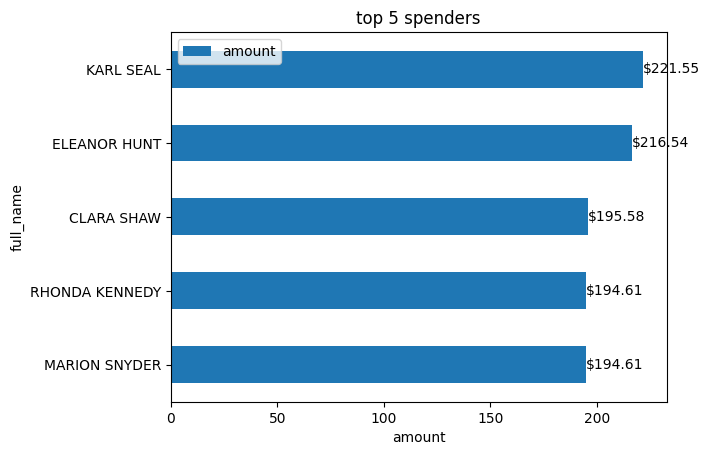

In [13]:
top_spender = duckdb.sql("""--sql
                        SELECT
                         CONCAT(c.first_name, ' ', c.last_name) AS full_name,
                         SUM(p.amount) AS amount
                        FROM payment p
                        LEFT JOIN customer c ON p.customer_id = c.customer_id
                        GROUP BY full_name
                        ORDER BY amount DESC
                        LIMIT 5;""").df()
ax = top_spender.head(5).plot(
    kind="barh",
    x="full_name",
    y="amount",
    title="top 5 spenders",
    xlabel="amount",
)
ax.bar_label(ax.containers[0], fmt='$%.2f')
ax.invert_yaxis()

- b) How much money does each film category bring in? Make a bar chart showing total revenue per film category.

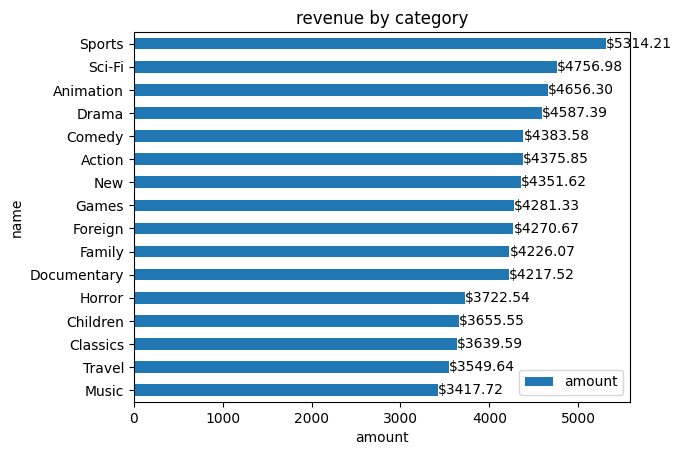

In [14]:
# b)
revenue_category = duckdb.sql("""--sql
                                SELECT c.name,
                                 SUM(p.amount) AS amount
                                FROM category c
                                LEFT JOIN film_category fc ON c.category_id = fc.category_id
                                LEFT JOIN film f ON fc.film_id = f.film_id
                                LEFT JOIN inventory i ON f.film_id = i.film_id
                                LEFT JOIN rental r ON i.inventory_id = r.inventory_id
                                LEFT JOIN payment p ON r.rental_id = p.rental_id
                                GROUP BY c.name
                                ORDER BY amount DESC;""").df()

ax = revenue_category.plot(
    kind="barh",
    x="name",
    y="amount",
    title="revenue by category",
    xlabel="amount",
)
ax.bar_label(ax.containers[0], fmt='$%.2f')
ax.invert_yaxis()